In [ ]:
import torch
import torchvision
import os
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
!pip install openai-clip
import clip
import pandas as pd
import itertools
import numpy as np
import cv2
import json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 4.8 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=02ceabe8bc38e0754ddfea269e88976d5a950bf4ed6c84f793f5256076c424a6
  Stored in directory: /root/.cache/pip/wheels/08/77/8e/8d2f862df6bf7fb4e2007062d2cbaeae49862ec7b56d041229
Successfully built openai-clip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/My Drive/train.zip" "train.zip"
!unzip -q train.zip
!cp "/content/drive/My Drive/train1.zip" "train1.zip"
!unzip -q train1.zip

Mounted at /content/drive


In [ ]:
!cp -a /content/train1/. /content/train/

In [ ]:
import os
from sklearn.model_selection import train_test_split
image_folder=r'/content/train'

df=pd.read_csv(image_folder+'/_classes.csv')
files=df["filename"].values.tolist()
df.drop(['filename'], axis=1,inplace=True)
tags=list(df.columns)
labels=df.to_numpy()

x, test_files, y, test_target = train_test_split(files,labels,test_size=0.1,train_size=0.9)
train_files, val_files, train_target, val_target = train_test_split(x,y,test_size = 0.2,train_size =0.8)

print(f'{len(train_files)}, {len(train_target)}')
print(f'{len(val_files)}, {len(val_target)}')
print(f'{len(test_files)}, {len(test_target)}')


10869, 10869
2718, 2718
1510, 1510


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, target, transforms=None):
        self.root = root
        self.files = files
        self.target = target
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        target_ = self.target[item]
        if self.transforms:
            image = self.transforms(image)
        return image, target_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 12 #
batch_size_test = 12#

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                               torchvision.transforms.RandomHorizontalFlip(),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                                 )
test_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                                 )
#image datasets
train_dataset = Hist('/content/train/', train_files, train_target,
                         transforms=image_transform)
val_dataset = Hist('/content/train/', val_files, val_target,
                        transforms=image_transform)
test_dataset = Hist('/content/train/', test_files, test_target,
                        transforms=test_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train,
                                           shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=batch_size_test,
                                          shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test,
                                          shuffle=False, num_workers=2)

Label:  [' natural-landscapes']


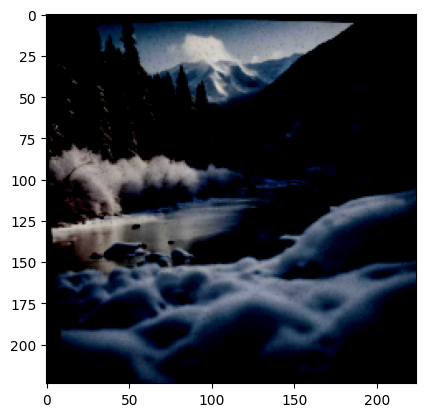

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
l_str=[]
for s in range(10):
  if labels[0][s]==1:
    l_str.append(tags[s])
print("Label: ", l_str)

In [ ]:
from torch.nn import functional as F
from torchvision import datasets, models, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

criterion = nn.BCEWithLogitsLoss()

output_dim = 15
model = models.resnet50(pretrained=True).to(device)


model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, output_dim)).to(device)
for param in model.parameters():
  param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30000,60000,90000], gamma=0.97)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s]


In [ ]:
from numpy.lib.type_check import imag
from sklearn.metrics import accuracy_score, f1_score
import torchvision.transforms as T


def train_model(model,device, train_loader, optimizer,scheduler,criterion):

  model = model.to(device)

  total_loss = 0.0

  model.train()
  for images, targets in train_loader:
    images, targets = images.to(device),targets.float().to(device)

    outputs = model(images)
    #outputs = torch.sigmoid(outputs)

    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    total_loss += loss.item()

  return total_loss


def validation(model, device, val_loader,criterion):
  model = model.to(device)

  model.eval()

  y_true_val = []
  y_pred_val = []
  y=[]
  y_pred=[]

  total_loss=0

  with torch.no_grad():
    for images, targets in val_loader:
      images = images.to(device)
      targets = targets.float().to(device)  # Convert targets to float and move to device


      outputs = model(images)

      loss = criterion(outputs, targets)

      pred = (outputs >= 0.5).float()
      total_loss += loss.item()


      y_true_val.extend(targets.cpu().tolist())
      y_pred_val.extend(pred.cpu().tolist())
      y.append(y_true_val)
      y_pred.append(y_pred_val)

    y=np.array(y)
    y=np.reshape(y,(-1,15))
    y_pred=np.array(y_pred)
    y_pred=np.reshape(y_pred,(-1,15))

  hamming=f1_score(y,y_pred,average='weighted')

  return total_loss,y,y_pred,hamming

def test(model,device, test_loader,criterion):

  model = model.to(device)

  model.eval()

  y_true_val = []
  y_pred_val = []
  y=[]
  y_pred=[]
  total_loss=0
  img=[]
  img1=[]
  transform = T.ToPILImage()
  with torch.no_grad():
    for images, targets in test_loader:
      images = images.to(device)
      targets = targets.float().to(device)  # Convert targets to float and move to device


      outputs = model(images)

      loss = criterion(outputs, targets)
      pred = (outputs >= 0.5).float()
      total_loss += loss.item()



      y_true_val.extend(targets.cpu().tolist())
      y_pred_val.extend(pred.cpu().tolist())
      y.append(y_true_val)
      y_pred.append(y_pred_val)

    y=np.array(y)
    y=np.reshape(y,(-1,15))
    y_pred=np.array(y_pred)
    y_pred=np.reshape(y_pred,(-1,15))

  hamming=f1_score(y,y_pred,average='weighted')

  return total_loss,y,y_pred,hamming

In [ ]:

num_epochs = 50
Acc=0

for epoch in range(num_epochs):
  total_loss=train_model(model,device, train_loader, optimizer,scheduler,criterion)
  print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss/len(train_loader):.4f}")

  total_val_loss,target,predictions,hamming=validation(model, device, val_loader,criterion)




  print(f"Validation Loss: {total_val_loss/len(val_loader):.4f}, Validation F1 score (weighted): {hamming*100:.4f}%")

  if Acc<hamming:
    torch.save(model.state_dict(), 'Decoder.pth')
    Acc=hamming
    y=target
    y_pred=predictions


Epoch [1/50], Train Loss: 0.3143
Validation Loss: 0.3100, Validation F1 score (weighted): 33.7329%
Epoch [2/50], Train Loss: 0.2923
Validation Loss: 0.3208, Validation F1 score (weighted): 42.0254%
Epoch [3/50], Train Loss: 0.2769
Validation Loss: 0.3136, Validation F1 score (weighted): 38.0214%
Epoch [4/50], Train Loss: 0.2651
Validation Loss: 0.2738, Validation F1 score (weighted): 46.5023%
Epoch [5/50], Train Loss: 0.2536
Validation Loss: 0.2482, Validation F1 score (weighted): 55.2153%
Epoch [6/50], Train Loss: 0.2437
Validation Loss: 0.2520, Validation F1 score (weighted): 55.0543%
Epoch [7/50], Train Loss: 0.2334
Validation Loss: 0.2439, Validation F1 score (weighted): 59.1709%
Epoch [8/50], Train Loss: 0.2243
Validation Loss: 0.2304, Validation F1 score (weighted): 60.2271%
Epoch [9/50], Train Loss: 0.2165
Validation Loss: 0.2148, Validation F1 score (weighted): 64.7996%
Epoch [10/50], Train Loss: 0.2083
Validation Loss: 0.2122, Validation F1 score (weighted): 65.5296%
Epoch [11

In [ ]:
from sklearn.metrics import precision_score
print(f'Best F1 score (weighted): {Acc*100:.2f}% \n\n')
score=np.zeros(15)
for i in range(15):
    score[i]=f1_score(y[:,i],y_pred[:,i])
i=0
Dic_f1=dict(zip(tags,score))
print('F1 score for each label: \n')
for keys in Dic_f1:
  print(f'{keys}: {Dic_f1[keys]*100:.2f}%')

Best F1 score (weighted): 86.40% 


F1 score for each label: 

 architectural landscape: 71.13%
 buildings: 81.01%
 huts_houses: 76.19%
 images-of-sky-cosmic-events: 77.55%
 marine: 87.79%
 natural-landscapes: 89.83%
 natural-patterns: 66.67%
 nonsignificantly-bio: 88.14%
 presence-of-animals: 75.63%
 presence-of-humans: 87.14%
 presence-of-plants: 92.95%
 presence-of-water: 87.17%
 seascape: 84.77%
 seasonal-weather-phenomenon: 88.39%
 still-life: 88.61%


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred,target_names=tags,zero_division=0))

                              precision    recall  f1-score   support

     architectural landscape       0.93      0.57      0.71     27240
                   buildings       0.76      0.87      0.81     41768
                 huts_houses       0.89      0.66      0.76     62879
 images-of-sky-cosmic-events       0.76      0.79      0.78     10896
                      marine       0.89      0.86      0.88     30191
          natural-landscapes       0.93      0.87      0.90    244252
            natural-patterns       0.95      0.51      0.67     24743
        nonsignificantly-bio       0.90      0.87      0.88     71959
         presence-of-animals       0.92      0.64      0.76    149593
          presence-of-humans       0.94      0.81      0.87    301002
          presence-of-plants       0.91      0.95      0.93    300094
           presence-of-water       0.92      0.83      0.87    203619
                    seascape       0.93      0.78      0.85     29964
 seasonal-weather-p

In [ ]:
model=models.resnet50(pretrained=True).to(device)


model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, output_dim)).to(device)
for param in model.parameters():
  param.requires_grad = False
model.load_state_dict(torch.load('Decoder.pth', map_location=device))
model=model.to(device)
test_loss,test_target,test_predictions,f1=test(model, device, test_loader,criterion)

print(classification_report(test_target, test_predictions,target_names=tags,zero_division=0))

print(f'Weighted F1 score on test dataset: {f1*100:.2f}%')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


                              precision    recall  f1-score   support

     architectural landscape       0.85      0.67      0.75      9450
                   buildings       0.82      0.91      0.86     13482
                 huts_houses       0.87      0.74      0.80     21042
 images-of-sky-cosmic-events       0.80      0.69      0.74      4410
                      marine       0.77      0.90      0.83      6048
          natural-landscapes       0.95      0.89      0.92     77994
            natural-patterns       1.00      0.49      0.66      4914
        nonsignificantly-bio       0.96      0.88      0.92     22176
         presence-of-animals       0.91      0.70      0.79     49644
          presence-of-humans       0.93      0.84      0.89     93240
          presence-of-plants       0.93      0.96      0.94     94500
           presence-of-water       0.92      0.84      0.88     61110
                    seascape       0.91      0.77      0.83      9450
 seasonal-weather-p

In [ ]:
def get_string(arr,tags):
  if sum(arr)==0:
    arr[7]=1
  label=''
  for i in range(15):
    if arr[i]==1:
      label=label+tags[i]+', '
  label=label[:-2]
  return label


Actual Tags: presence-of-water, seascape
Predicted Tags: presence-of-water, seascape


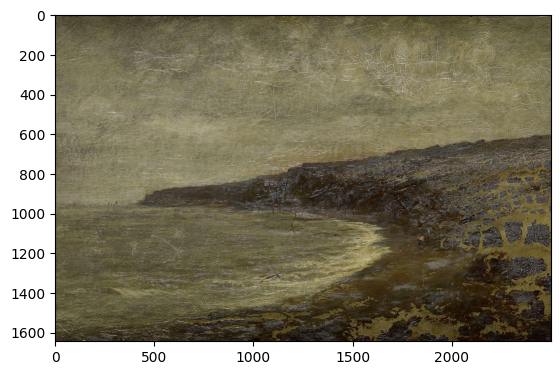

In [ ]:
from itertools import chain
import random
import torchvision
from torchvision import models, transforms

def test_one_image(i):
  img=test_files[i]
  image_class= test_target[i]

  transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to match model's input size
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
  ])
  tags=['architectural landscape','buildinggs','houses','cosmic-bodies','marine','natural-landscapes','natural-patterns','nonsignificantly-bio','presence-of-animals','presence-of-humans','plants-and-trees','presence-of-water','seascape','seasonal-and-natural-phenomenon','still-life']

  image_path=os.path.join('/content/Biophilic_Art_Datasetv2/train/', img)
  decoder=Decoder(input_dim, output_dim).to(device)
  decoder.load_state_dict(torch.load('Decoder.pth', map_location=device))
  image = Image.open(image_path)
  image = transform(image)
  image = image.unsqueeze(0)
  image=image.to(device)
  decoder.eval()
  with torch.no_grad():
    image_features = model.encode_image(image)
  image_features=image_features.to(torch.float32)
  outputs = decoder(image_features)
  pred = (outputs >= 0.5).float()
  pred = pred.cpu().tolist()
  pred=list(chain.from_iterable(pred))
  actual_tag=get_string(image_class,tags)
  predicted_tag=get_string(pred,tags)

  print(f'Actual Tags: {actual_tag}\nPredicted Tags: {predicted_tag}')

  image_path = '/content/Biophilic_Art_Datasetv2/train/'+test_files[i]

  image = Image.open(image_path)
  plt.imshow(image)


test_one_image(4)

Actual Tags: houses, natural-landscapes, presence-of-animals, presence-of-humans
Predicted Tags: houses, natural-landscapes, presence-of-humans, plants-and-trees


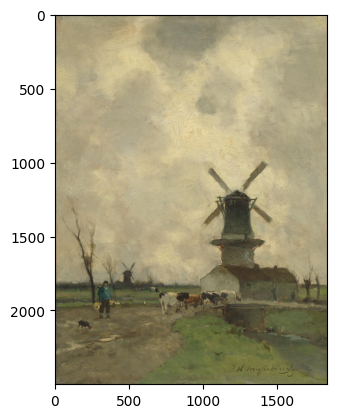

In [ ]:
test_one_image(8)

Actual Tags: presence-of-animals
Predicted Tags: presence-of-animals


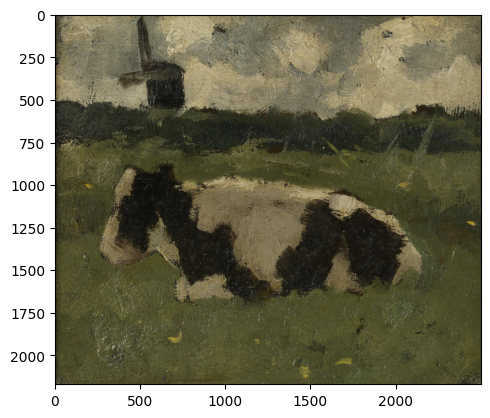

In [ ]:
test_one_image(12)

Actual Tags: natural-landscapes, presence-of-animals, presence-of-humans, plants-and-trees, presence-of-water
Predicted Tags: natural-landscapes, presence-of-animals, presence-of-humans, plants-and-trees, presence-of-water


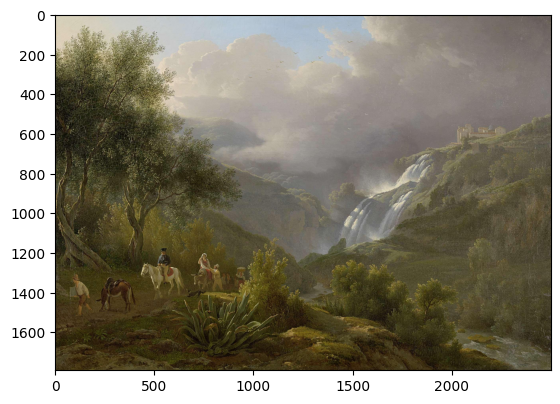

In [ ]:
test_one_image(15)

Actual Tags: natural-landscapes, plants-and-trees, seasonal-and-natural-phenomenon
Predicted Tags: natural-landscapes, plants-and-trees, seasonal-and-natural-phenomenon


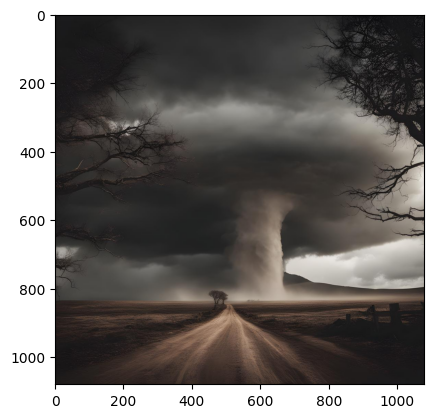

In [ ]:
test_one_image(17)

Actual Tags: presence-of-humans, plants-and-trees, presence-of-water
Predicted Tags: presence-of-humans, presence-of-water


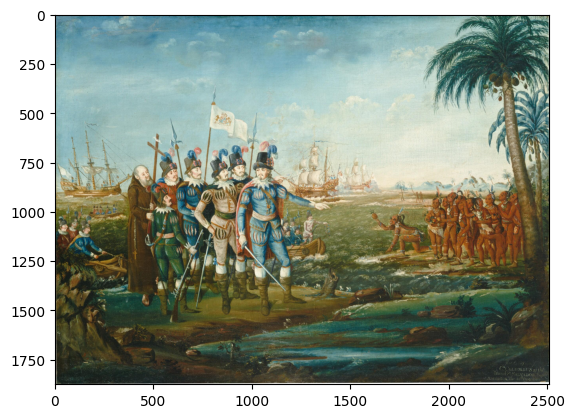

In [ ]:
test_one_image(38)

Actual Tags: natural-landscapes, plants-and-trees, presence-of-water, seasonal-and-natural-phenomenon
Predicted Tags: natural-landscapes, plants-and-trees, presence-of-water, seasonal-and-natural-phenomenon


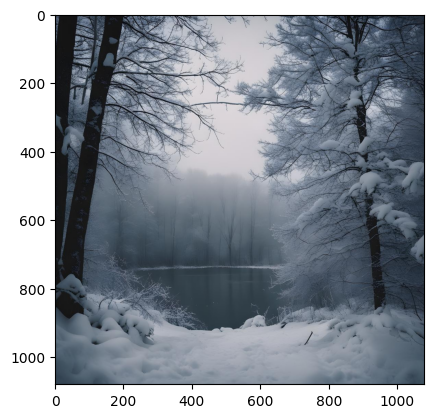

In [ ]:
test_one_image(24)

Actual Tags: still-life
Predicted Tags: still-life


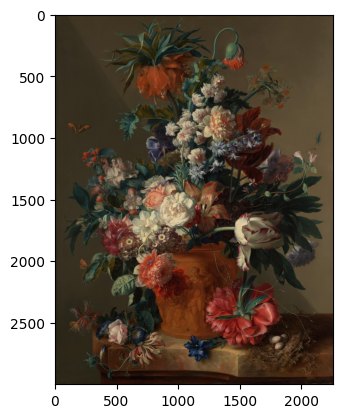

In [ ]:
test_one_image(40)

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=568917cd6e72354034c61be588480cc15ae347a492173c929ed552e68b85bd4d
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from torchvision import transforms
def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((224, 224))
    ])

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

def batch_predict(images):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    decoder.to(device)
    decoder.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    batch = batch.to(device)

    with torch.no_grad():
        image_features = model.encode_image(batch)
    image_features=image_features.to(torch.float32)




    logits = decoder(image_features)
    probs = F.softmax(logits, dim=1)

    return probs.detach().cpu().numpy()

In [ ]:
from itertools import chain
import lime
from lime import lime_image
import torchvision
from torchvision import models, transforms
from skimage.segmentation import mark_boundaries

def get_explanation(i):
  img=test_files[i]
  image_class= test_target[i]

  transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to match model's input size
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
  ])

  image_path=os.path.join('train/', img)
  decoder=Decoder(input_dim, output_dim).to(device)
  decoder.load_state_dict(torch.load('Decoder.pth', map_location=device))
  image = Image.open(image_path)
  image = transform(image)
  image = image.unsqueeze(0)
  image=image.to(device)
  decoder.eval()
  with torch.no_grad():
    image_features = model.encode_image(image)
  image_features=image_features.to(torch.float32)
  outputs = decoder(image_features)


  pred = outputs.cpu().tolist()
  pred=list(chain.from_iterable(pred))
  pred=[round(num, 2) for num in pred]



  image_path = 'train/'+test_files[i]

  image = Image.open(image_path)



  explainer = lime_image.LimeImageExplainer()
  explanation = explainer.explain_instance(np.array(pill_transf(image)),
                                         batch_predict, # classification function
                                         top_labels=10,
                                         hide_color=0,
                                         num_samples=1000)
  '''temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
  img_boundry1 = mark_boundaries(temp/255.0, mask)


  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
  img_boundry2 = mark_boundaries(temp/255.0, mask)'''

  image_path = 'train/'+test_files[i]

  image = Image.open(image_path)
  plt.imshow(image)

  top_label=explanation.top_labels[0]
  top_class=tags[top_label]

  txt='Predicted Dominant Label: '+top_class
  print(txt)










  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted Dominant Label:  presence-of-humans


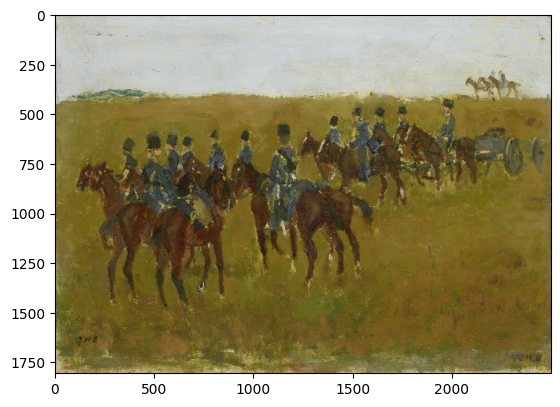

In [ ]:
get_explanation(4)

  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted Dominant Label:  seasonal-natural-phenomenon


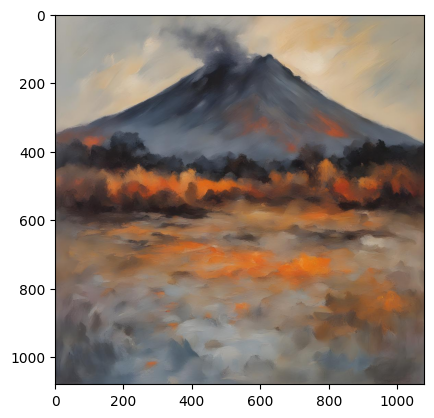

In [ ]:
get_explanation(8)

  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted Dominant Label:  presence-of-plants-trees


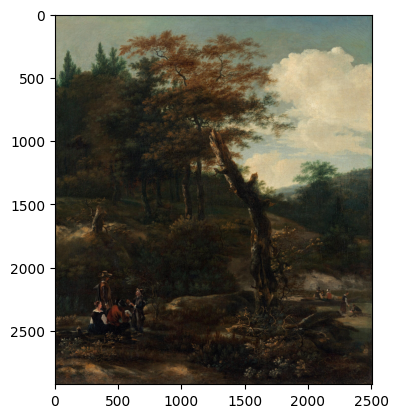

In [ ]:
get_explanation(12)

  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted Dominant Label:  natural-landscapes


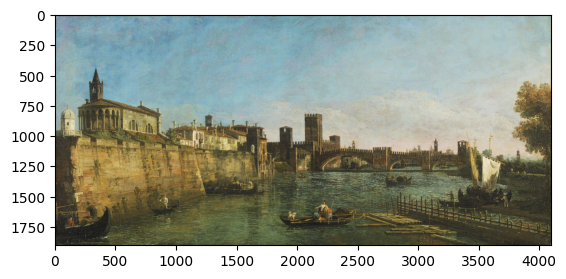

In [ ]:
get_explanation(13)

  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted Dominant Label:  natural-landscapes


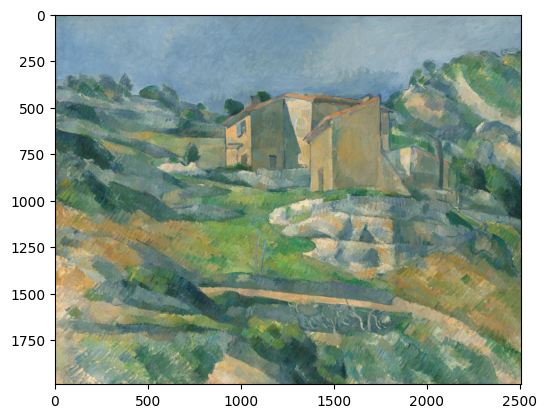

In [ ]:
get_explanation(17)

  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted Dominant Label:  presence-of-water


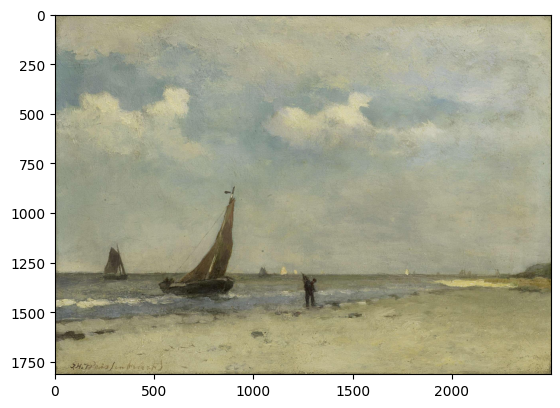

In [ ]:
get_explanation(38)

  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted Dominant Label:  presence-of-animals


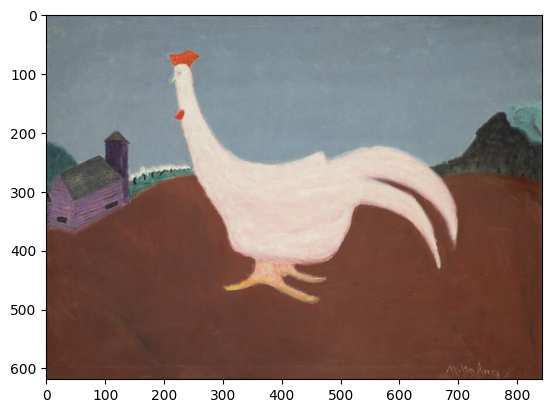

In [ ]:
get_explanation(22)

  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted Dominant Label:  presence-of-humans


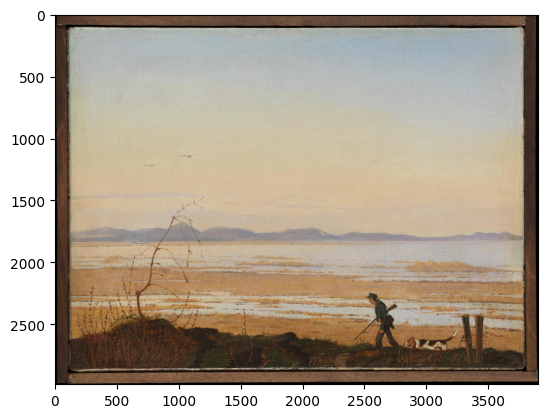

In [ ]:
get_explanation(24)

  0%|          | 0/1000 [00:00<?, ?it/s]

Predicted Dominant Label:  natural-landscapes


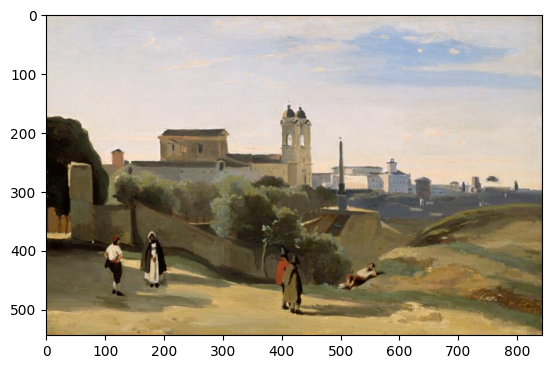

In [ ]:
get_explanation(40)

In [ ]:
import shutil
colab_link = "/content/Decoder.pth"
gdrive_link = "/content/drive/MyDrive/"
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/Decoder.pth'